In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, MultiHeadAttention, LayerNormalization, Lambda
import optuna
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import time

In [6]:
# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Students Social Media Addiction.csv')

In [7]:
# Data Preprocessing
data = data.dropna()

In [8]:
# Encode categorical variables
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data['Academic_Level'] = le.fit_transform(data['Academic_Level'])
data['Country'] = le.fit_transform(data['Country'])
data['Most_Used_Platform'] = le.fit_transform(data['Most_Used_Platform'])
data['Affects_Academic_Performance'] = le.fit_transform(data['Affects_Academic_Performance'])
data['Relationship_Status'] = le.fit_transform(data['Relationship_Status'])

# Discretize Addicted_Score
def discretize_addiction(score):
    if score <= 3:
        return 0  # Low
    elif score <= 6:
        return 1  # Medium
    else:
        return 2  # High

data['Addicted_Score_Category'] = data['Addicted_Score'].apply(discretize_addiction)


In [9]:
# Features and target
X = data.drop(['Student_ID', 'Addicted_Score', 'Addicted_Score_Category'], axis=1)
y = data['Addicted_Score_Category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# Reshape for 1D CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Pad for Xception (71x71x3)
xception_size = 71
features = X_train.shape[1]
repeat_factor = max(1, (xception_size + features - 1) // features)
X_train_repeated = np.repeat(X_train, repeat_factor, axis=1)[:, :xception_size]
X_test_repeated = np.repeat(X_test, repeat_factor, axis=1)[:, :xception_size]
X_train_xception = X_train_repeated.reshape(X_train.shape[0], xception_size, 1)
X_test_xception = X_test_repeated.reshape(X_test.shape[0], xception_size, 1)
X_train_xception = np.repeat(X_train_xception, 3, axis=2)  # (samples, xception_size, 3)
X_test_xception = np.repeat(X_test_xception, 3, axis=2)
X_train_xception = np.repeat(X_train_xception[:, :, np.newaxis, :], xception_size, axis=2)  # (samples, xception_size, xception_size, 3)
X_test_xception = np.repeat(X_test_xception[:, :, np.newaxis, :], xception_size, axis=2)

# Model performance dictionary
model_performance = {}


In [11]:
# Function to compute specificity
def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity_scores = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_scores.append(specificity)
    # Weighted average based on class support
    class_counts = np.bincount(y_true, minlength=len(cm))
    weights = class_counts / class_counts.sum()
    return np.average(specificity_scores, weights=weights)

In [12]:
# Bayesian Optimization for LightGBM
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20)
lgb = LGBMClassifier(**study_lgb.best_params)
start_time = time.time()
lgb.fit(X_train, y_train)
train_time_lgb = time.time() - start_time
y_pred_lgb = lgb.predict(X_test)
model_performance['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_lgb, average='weighted'),
    'f1': f1_score(y_test, y_pred_lgb, average='weighted'),
    'time': train_time_lgb,
    'specificity': compute_specificity(y_test, y_pred_lgb),
    'sensitivity': recall_score(y_test, y_pred_lgb, average='weighted')
}


[I 2025-05-28 18:44:01,968] A new study created in memory with name: no-name-805487b5-d93b-4254-ae1c-c964b9ec4665
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:02,183] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 233, 'max_depth': 4, 'learning_rate': 0.01454444052481069, 'num_leaves': 33}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:02,536] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 262, 'max_depth': 10, 'learning_rate': 0.02662660723554887, 'num_leaves': 47}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:02,827] Trial 2 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 226, 'max_depth': 10, 'learning_rate': 0.03017337586662494, 'num_leaves': 30}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:02,959] Trial 3 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.08518824555126006, 'num_leave

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:03,122] Trial 5 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.16462845590627978, 'num_leaves': 37}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:03,333] Trial 6 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.057135691689898155, 'num_leaves': 56}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:03,461] Trial 7 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 185, 'max_depth': 8, 'learning_rate': 0.13221868123748276, 'num_leaves': 60}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:03,805] Trial 8 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.020713735485473034, 'num_leaves': 38}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:03,963] Trial 9 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.022496497217035803, 'num_leaves': 54}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:04,175] Trial 10 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.01006780583569822, 'num_leaves': 87}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:04,662] Trial 11 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 293, 'max_depth': 8, 'learning_rate': 0.010456278873230217, 'num_leaves': 83}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:05,031] Trial 12 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.03611786579667348, 'num_leaves': 45}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:05,459] Trial 13 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.0171512251784518, 'num_leaves': 74}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:05,831] Trial 14 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 239, 'max_depth': 8, 'learning_rate': 0.04092851063879258, 'num_leaves': 47}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:05,971] Trial 15 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.015239721250804363, 'num_leav

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:06,346] Trial 16 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.05662509143822161, 'num_leaves': 73}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:06,636] Trial 17 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 147, 'max_depth': 9, 'learning_rate': 0.027640588301775227, 'num_leaves': 100}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:06,965] Trial 18 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.01552893784706721, 'num_leaves': 35}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 18:44:07,372] Trial 19 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.013242640863419562, 'num_leaves': 46}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Bayesian Optimization for CatBoost
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=20)
cat = CatBoostClassifier(**study_cat.best_params, verbose=0)
start_time = time.time()
cat.fit(X_train, y_train)
train_time_cat = time.time() - start_time
y_pred_cat = cat.predict(X_test)
model_performance['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_cat),
    'precision': precision_score(y_test, y_pred_cat, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_cat, average='weighted'),
    'f1': f1_score(y_test, y_pred_cat, average='weighted'),
    'time': train_time_cat,
    'specificity': compute_specificity(y_test, y_pred_cat),
    'sensitivity': recall_score(y_test, y_pred_cat, average='weighted')
}

[I 2025-05-28 18:44:12,490] A new study created in memory with name: no-name-46e3e782-6745-4338-a628-76a2b3d84977
[I 2025-05-28 18:44:13,115] Trial 0 finished with value: 0.9787234042553191 and parameters: {'iterations': 257, 'depth': 4, 'learning_rate': 0.019151002777927594}. Best is trial 0 with value: 0.9787234042553191.
[I 2025-05-28 18:44:14,423] Trial 1 finished with value: 0.9929078014184397 and parameters: {'iterations': 225, 'depth': 8, 'learning_rate': 0.05846437045094928}. Best is trial 1 with value: 0.9929078014184397.
[I 2025-05-28 18:44:15,874] Trial 2 finished with value: 0.9929078014184397 and parameters: {'iterations': 269, 'depth': 9, 'learning_rate': 0.031953639441893805}. Best is trial 1 with value: 0.9929078014184397.
[I 2025-05-28 18:44:17,650] Trial 3 finished with value: 0.9929078014184397 and parameters: {'iterations': 191, 'depth': 10, 'learning_rate': 0.04505990488515951}. Best is trial 1 with value: 0.9929078014184397.
[I 2025-05-28 18:44:18,156] Trial 4 fin

In [14]:
# Bayesian Optimization for SVM
def objective_svm(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
    }
    model = SVC(**params, probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=20)
svm = SVC(**study_svm.best_params, probability=True)
start_time = time.time()
svm.fit(X_train, y_train)
train_time_svm = time.time() - start_time
y_pred_svm = svm.predict(X_test)
model_performance['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    'time': train_time_svm,
    'specificity': compute_specificity(y_test, y_pred_svm),
    'sensitivity': recall_score(y_test, y_pred_svm, average='weighted')
}

[I 2025-05-28 18:44:38,313] A new study created in memory with name: no-name-5d152b56-3630-4cbd-aa33-4990804ee299
[I 2025-05-28 18:44:38,367] Trial 0 finished with value: 0.9716312056737588 and parameters: {'C': 3.37988851838202, 'kernel': 'linear'}. Best is trial 0 with value: 0.9716312056737588.
[I 2025-05-28 18:44:38,425] Trial 1 finished with value: 0.9787234042553191 and parameters: {'C': 5.558660428285579, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9787234042553191.
[I 2025-05-28 18:44:38,495] Trial 2 finished with value: 0.9645390070921985 and parameters: {'C': 0.4884954162663364, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9787234042553191.
[I 2025-05-28 18:44:38,572] Trial 3 finished with value: 0.950354609929078 and parameters: {'C': 0.297279392365289, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9787234042553191.
[I 2025-05-28 18:44:38,635] Trial 4 finished with value: 0.9645390070921985 and parameters: {'C': 0.6313980480776593, 'kernel': 'rbf'}. Best is trial 1 

In [15]:
# XGBoost + CNN Hybrid
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)
xgb = XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='mlogloss')
start_time = time.time()
xgb.fit(X_train, y_train)
train_time_xgb = time.time() - start_time

def build_cnn():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
start_time = time.time()
cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_time_cnn = time.time() - start_time
xgb_probs = xgb.predict_proba(X_test)
cnn_probs = cnn.predict(X_test_reshaped)
hybrid_xgb_cnn_probs = (xgb_probs + cnn_probs) / 2
y_pred_hybrid_xgb_cnn = np.argmax(hybrid_xgb_cnn_probs, axis=1)
model_performance['XGBoost+CNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_hybrid_xgb_cnn),
    'precision': precision_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted'),
    'f1': f1_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted'),
    'time': train_time_xgb + train_time_cnn,
    'specificity': compute_specificity(y_test, y_pred_hybrid_xgb_cnn),
    'sensitivity': recall_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted')
}


[I 2025-05-28 18:44:43,821] A new study created in memory with name: no-name-e0b45fdd-7d5f-4ef0-82cd-3276edd96125
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-28 18:44:44,030] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.016059221686544733}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-28 18:44:44,250] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.015421232770381233}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [16]:
# Gradient Boosting + SVM Hybrid
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=20)
gb = GradientBoostingClassifier(**study_gb.best_params)
start_time = time.time()
gb.fit(X_train, y_train)
train_time_gb = time.time() - start_time
gb_probs = gb.predict_proba(X_test)
svm_probs = svm.predict_proba(X_test)
hybrid_gb_svm_probs = (gb_probs + svm_probs) / 2
y_pred_hybrid_gb_svm = np.argmax(hybrid_gb_svm_probs, axis=1)
model_performance['Gradient Boosting+SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_hybrid_gb_svm),
    'precision': precision_score(y_test, y_pred_hybrid_gb_svm, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_hybrid_gb_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_hybrid_gb_svm, average='weighted'),
    'time': train_time_gb + train_time_svm,
    'specificity': compute_specificity(y_test, y_pred_hybrid_gb_svm),
    'sensitivity': recall_score(y_test, y_pred_hybrid_gb_svm, average='weighted')
}

[I 2025-05-28 18:45:17,733] A new study created in memory with name: no-name-3f3cdacb-8f7c-45f3-b27d-c42616f689af
[I 2025-05-28 18:45:18,657] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 169, 'max_depth': 4, 'learning_rate': 0.03785026460759873}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 18:45:19,880] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 233, 'max_depth': 5, 'learning_rate': 0.06040009179132495}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 18:45:20,873] Trial 2 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 243, 'max_depth': 7, 'learning_rate': 0.21674323215141544}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 18:45:22,117] Trial 3 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 263, 'max_depth': 8, 'learning_rate': 0.13143816411458223}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 18:4

In [17]:
# MLP for Tabular Data
def build_mlp():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mlp = build_mlp()
start_time = time.time()
mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_time_mlp = time.time() - start_time
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
model_performance['MLP'] = {
    'accuracy': accuracy_score(y_test, y_pred_mlp),
    'precision': precision_score(y_test, y_pred_mlp, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_mlp, average='weighted'),
    'f1': f1_score(y_test, y_pred_mlp, average='weighted'),
    'time': train_time_mlp,
    'specificity': compute_specificity(y_test, y_pred_mlp),
    'sensitivity': recall_score(y_test, y_pred_mlp, average='weighted')
}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [18]:
# Tabular Transformer
def build_tabular_transformer():
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(64)(inputs)
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # (None, 1, 64)
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attention)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

transformer = build_tabular_transformer()
start_time = time.time()
transformer.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_transformer = time.time() - start_time
y_pred_transformer = np.argmax(transformer.predict(X_test), axis=1)
model_performance['Tabular Transformer'] = {
    'accuracy': accuracy_score(y_test, y_pred_transformer),
    'precision': precision_score(y_test, y_pred_transformer, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_transformer, average='weighted'),
    'f1': f1_score(y_test, y_pred_transformer, average='weighted'),
    'time': train_time_transformer,
    'specificity': compute_specificity(y_test, y_pred_transformer),
    'sensitivity': recall_score(y_test, y_pred_transformer, average='weighted')
}


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [19]:
# Xception
def build_xception():
    base_model = tf.keras.applications.Xception(include_top=False, input_shape=(71, 71, 3), weights=None)
    inputs = Input(shape=(71, 71, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

xception = build_xception()
start_time = time.time()
xception.fit(X_train_xception, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_xception = time.time() - start_time
y_pred_xception = np.argmax(xception.predict(X_test_xception), axis=1)
model_performance['Xception'] = {
    'accuracy': accuracy_score(y_test, y_pred_xception),
    'precision': precision_score(y_test, y_pred_xception, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_xception, average='weighted'),
    'f1': f1_score(y_test, y_pred_xception, average='weighted'),
    'time': train_time_xception,
    'specificity': compute_specificity(y_test, y_pred_xception),
    'sensitivity': recall_score(y_test, y_pred_xception, average='weighted')
}

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [20]:
# Summary Table
summary_data = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Time (s)': [],
    'Specificity': [],
    'Sensitivity': []
}
for model, metrics in model_performance.items():
    summary_data['Model'].append(model)
    summary_data['Accuracy'].append(metrics['accuracy'])
    summary_data['Precision'].append(metrics['precision'])
    summary_data['Recall'].append(metrics['recall'])
    summary_data['F1-Score'].append(metrics['f1'])
    summary_data['Time (s)'].append(metrics['time'])
    summary_data['Specificity'].append(metrics['specificity'])
    summary_data['Sensitivity'].append(metrics['sensitivity'])

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)  # Round to 4 decimal places
print("\nSummary Table of Model Performance:")
print(summary_df.to_string(index=False))



Summary Table of Model Performance:
                Model  Accuracy  Precision  Recall  F1-Score  Time (s)  Specificity  Sensitivity
             LightGBM    0.9858     0.9859  0.9858    0.9851    0.2332       0.9859       0.9858
             CatBoost    0.9929     0.9930  0.9929    0.9929    0.8283       0.9910       0.9929
                  SVM    0.9858     0.9858  0.9858    0.9858    0.0438       0.9859       0.9858
          XGBoost+CNN    0.9858     0.9859  0.9858    0.9851   24.0430       0.9859       0.9858
Gradient Boosting+SVM    0.9858     0.9859  0.9858    0.9851    1.0006       0.9859       0.9858
                  MLP    0.9858     0.9859  0.9858    0.9851   14.4531       0.9859       0.9858
  Tabular Transformer    0.9716     0.9722  0.9716    0.9709   10.5045       0.9678       0.9716
             Xception    0.4184     0.1751  0.4184    0.2469 1637.2805       0.5816       0.4184


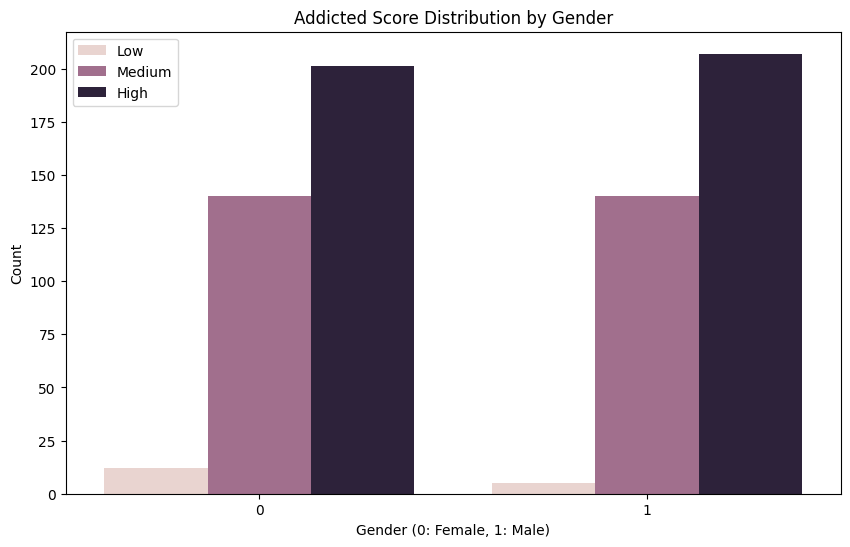

In [21]:
# Bar Graph: Addicted_Score by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Gender', hue='Addicted_Score_Category')
plt.title('Addicted Score Distribution by Gender')
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

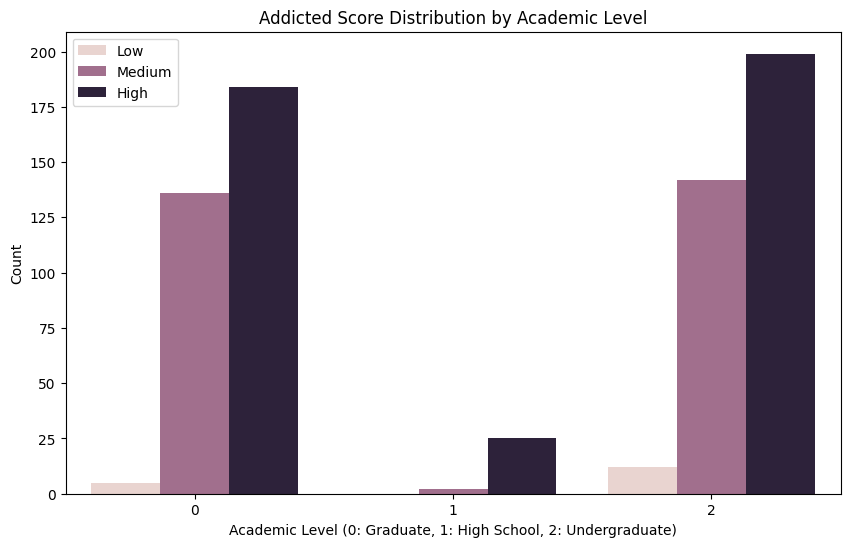

In [22]:

# Bar Graph: Addicted_Score by Academic_Level
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Academic_Level', hue='Addicted_Score_Category')
plt.title('Addicted Score Distribution by Academic Level')
plt.xlabel('Academic Level (0: Graduate, 1: High School, 2: Undergraduate)')
plt.ylabel('Count')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

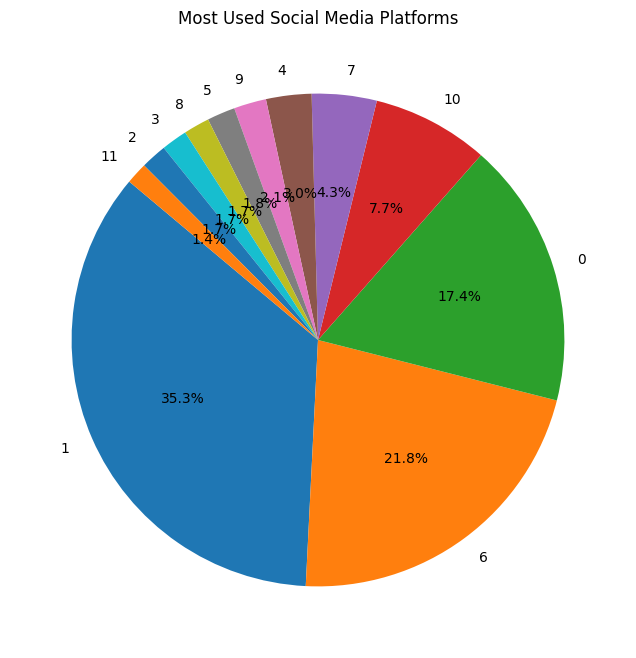

In [23]:
# Pie Chart: Most Used Platform
platform_counts = data['Most_Used_Platform'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(platform_counts, labels=platform_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Most Used Social Media Platforms')
plt.show()

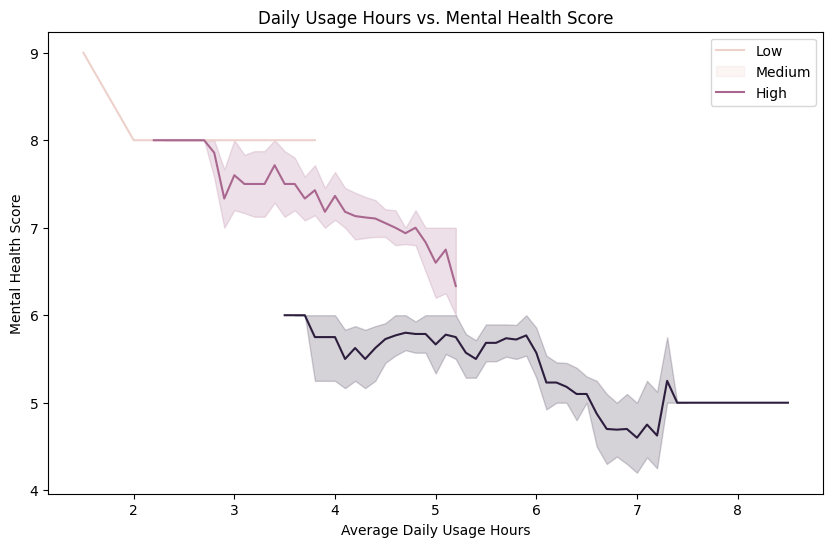

In [24]:
# Line Graph: Avg_Daily_Usage_Hours vs. Mental_Health_Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Avg_Daily_Usage_Hours', y='Mental_Health_Score', hue='Addicted_Score_Category')
plt.title('Daily Usage Hours vs. Mental Health Score')
plt.xlabel('Average Daily Usage Hours')
plt.ylabel('Mental Health Score')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step


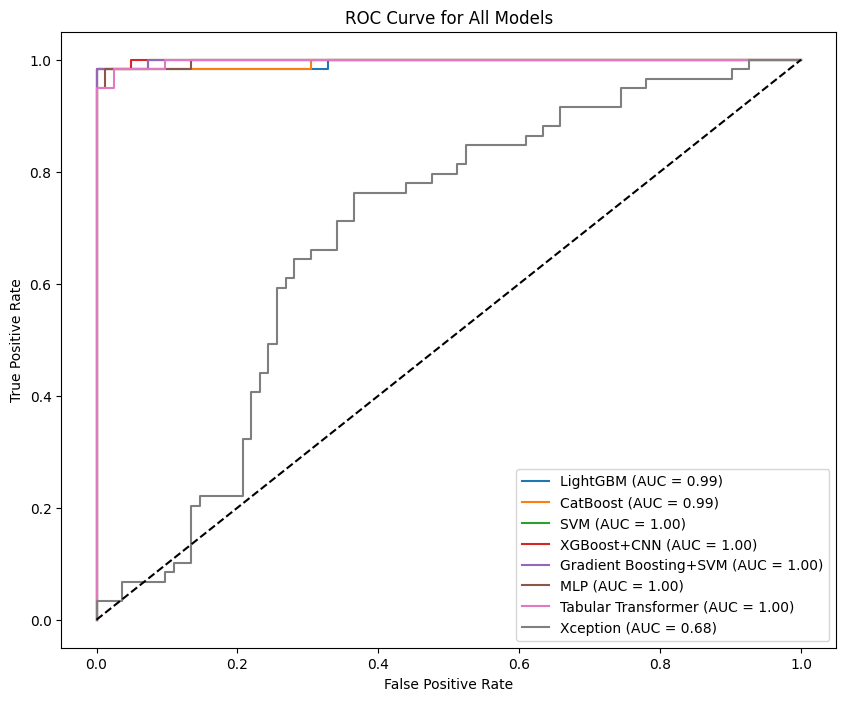

In [25]:
# ROC Curve for all models
plt.figure(figsize=(10, 8))
for name, model in [('LightGBM', lgb), ('CatBoost', cat), ('SVM', svm)]:
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

for name, model in [('XGBoost+CNN', hybrid_xgb_cnn_probs), ('Gradient Boosting+SVM', hybrid_gb_svm_probs)]:
    fpr, tpr, _ = roc_curve(y_test, model[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

for name, model in [('MLP', mlp), ('Tabular Transformer', transformer)]:
    y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

y_score_xception = xception.predict(X_test_xception)
fpr, tpr, _ = roc_curve(y_test, y_score_xception[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Xception (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()

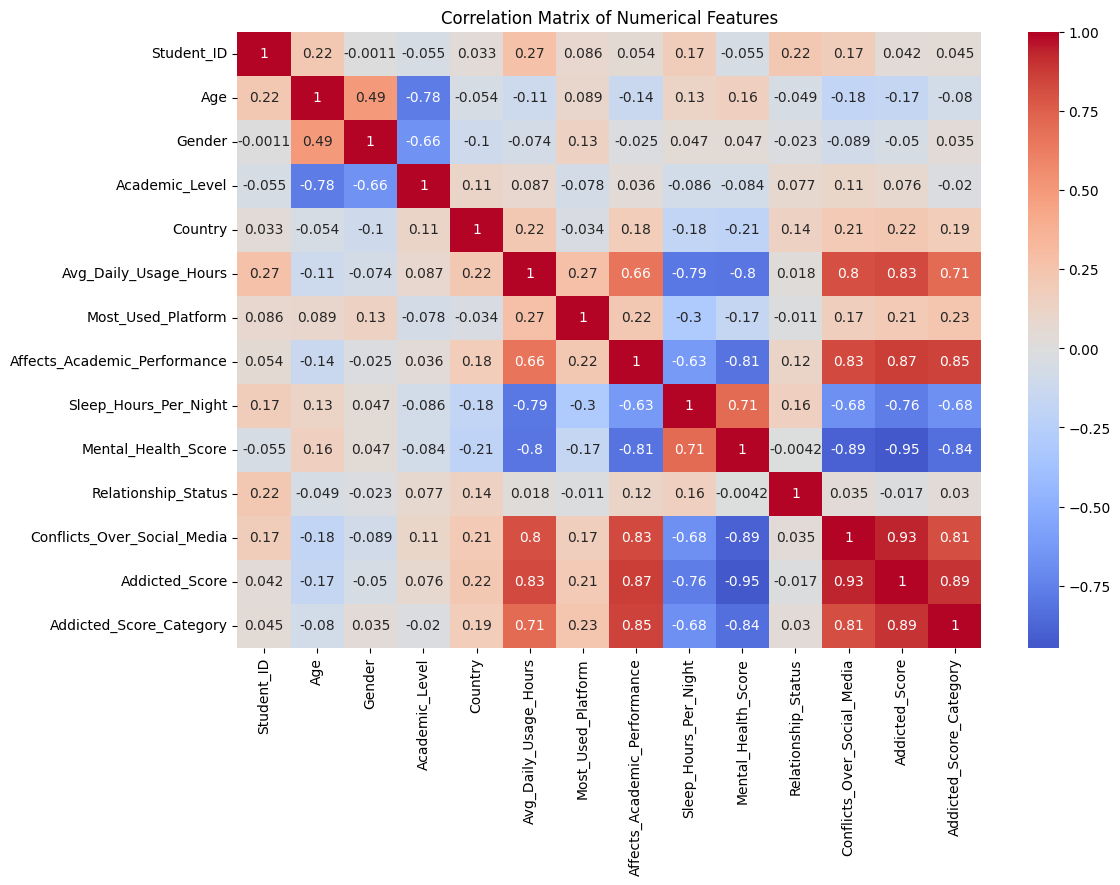

In [26]:
# Heatmap: Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [27]:
# Scatter Plot: Usage vs. Sleep Hours
fig = px.scatter(data, x='Avg_Daily_Usage_Hours', y='Sleep_Hours_Per_Night', color='Addicted_Score_Category', title='Usage Hours vs. Sleep Hours')
fig.update_layout(xaxis_title='Average Daily Usage Hours', yaxis_title='Sleep Hours Per Night')
fig.update_traces(marker=dict(size=10))
fig.show()


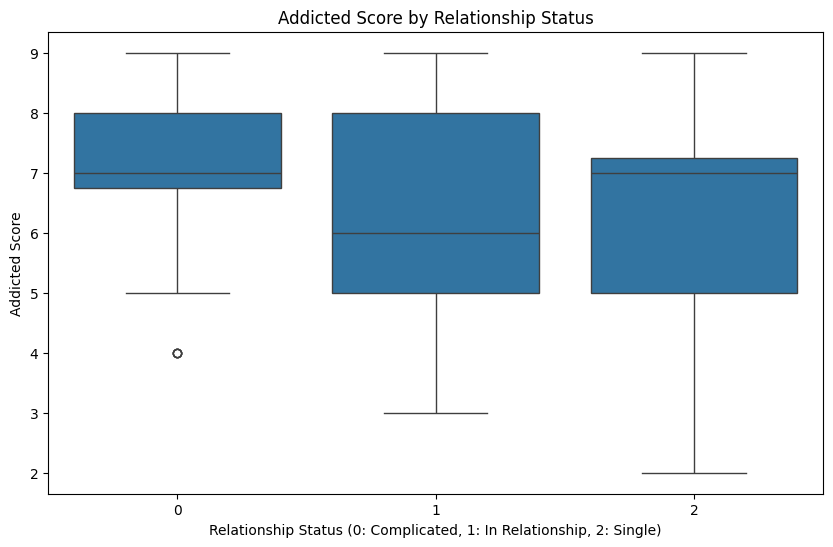

In [28]:
# Box Plot: Addicted_Score by Relationship_Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Relationship_Status', y='Addicted_Score')
plt.title('Addicted Score by Relationship Status')
plt.xlabel('Relationship Status (0: Complicated, 1: In Relationship, 2: Single)')
plt.ylabel('Addicted Score')
plt.show()

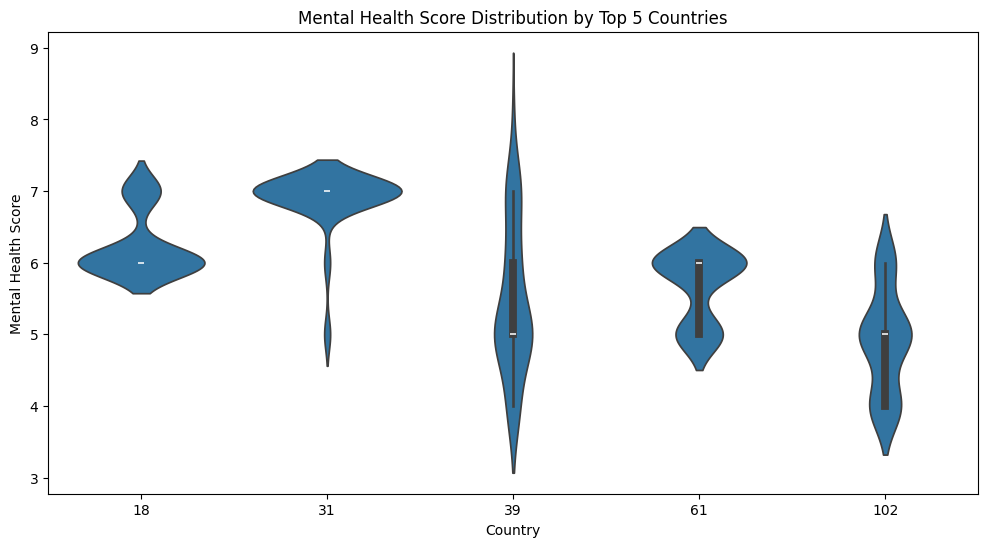

In [29]:

# Violin Plot: Mental_Health_Score by Country (Top 5 Countries)
top_countries = data['Country'].value_counts().index[:5]
filtered_data = data[data['Country'].isin(top_countries)]
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_data, x='Country', y='Mental_Health_Score')
plt.title('Mental Health Score Distribution by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Mental Health Score')
plt.show()

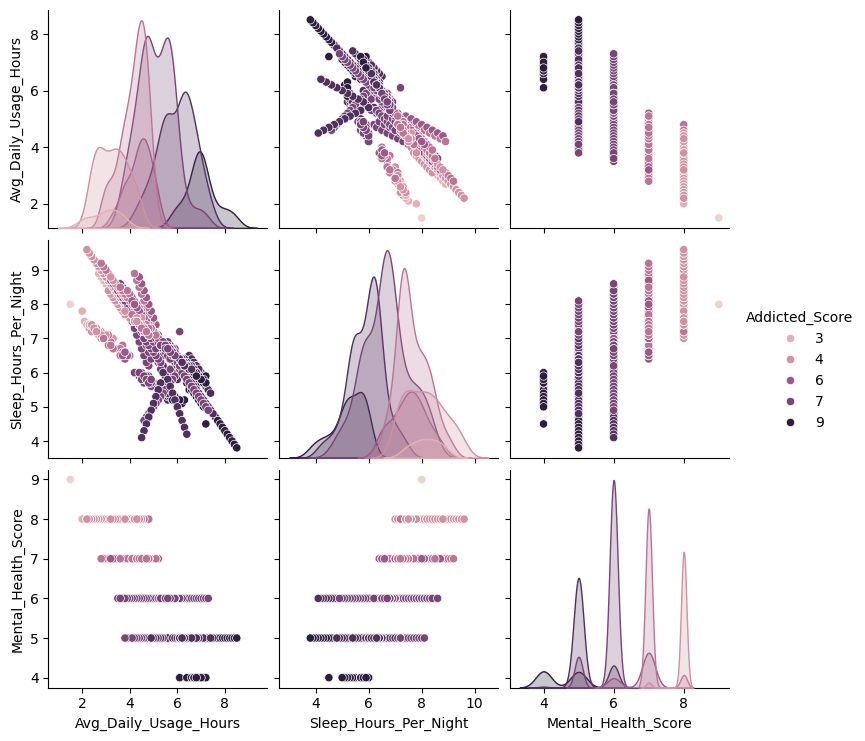

In [30]:
# Pair Plot
sns.pairplot(data[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Addicted_Score']], hue='Addicted_Score')
plt.show()

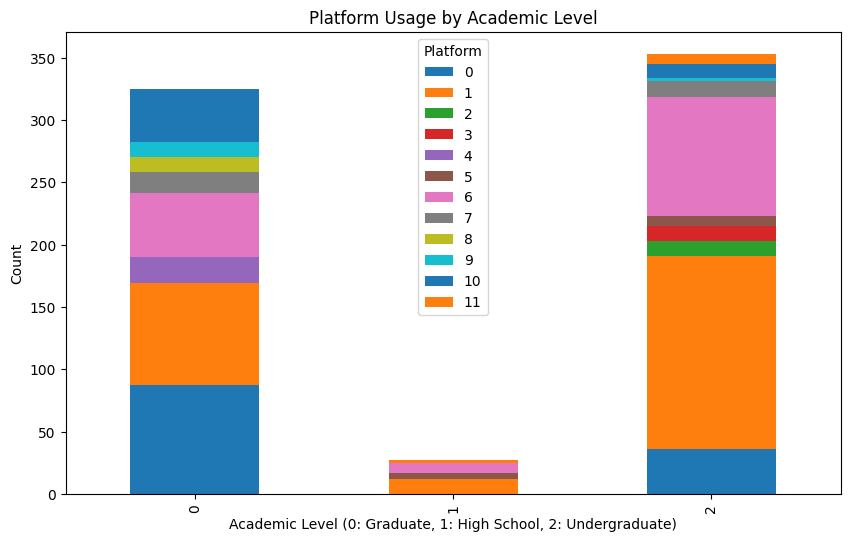

In [31]:
# Stacked Bar Chart: Platform Usage by Academic Level
platform_academic = data.groupby(['Academic_Level', 'Most_Used_Platform']).size().unstack().fillna(0)
platform_academic.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Platform Usage by Academic Level')
plt.xlabel('Academic Level (0: Graduate, 1: High School, 2: Undergraduate)')
plt.ylabel('Count')
plt.legend(title='Platform')
plt.show()

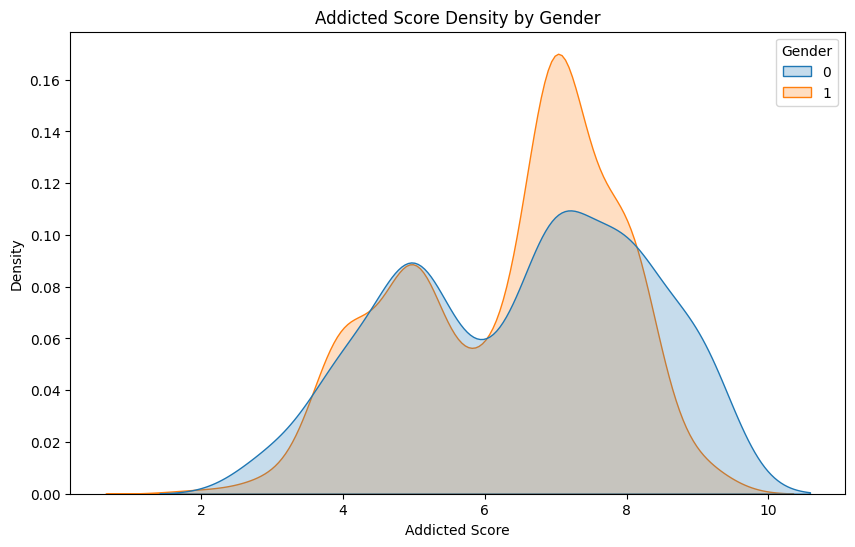

In [32]:
# KDE Plot: Addicted_Score by Gender
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Addicted_Score', hue='Gender', fill=True)
plt.title('Addicted Score Density by Gender')
plt.xlabel('Addicted Score')
plt.ylabel('Density')
plt.show()